Using perceptual loss as described in http://arxiv.org/abs/1603.08155

Steps:
    1. Create VGG
    2. Create FW network which takes content image as input and super resolution image as output where loss function = MSE(OP, IP)

In [1]:
%matplotlib inline
import importlib
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

Using TensorFlow backend.


In [25]:
import sys
sys.path.append('../PreTrainedModels')
from vgg16_avg import VGG16_Avg

In [87]:
import sys
sys.path.append('../utilities')
import utils2; importlib.reload(utils2)
from utils2 import *

In [27]:
limit_mem()

# Read data

In [28]:
dpath='/home/sravya/data/'

In [29]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

In [30]:
arr_lr.shape

(19439, 72, 72, 3)

In [31]:
arr_hr.shape

(19439, 288, 288, 3)

# Create VGG

In [32]:
# Explore
arr_hr.shape[1:]

(288, 288, 3)

In [33]:
vgg_inp=Input(arr_hr.shape[1:])
vgg= VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

# Architecture for Image transformation network

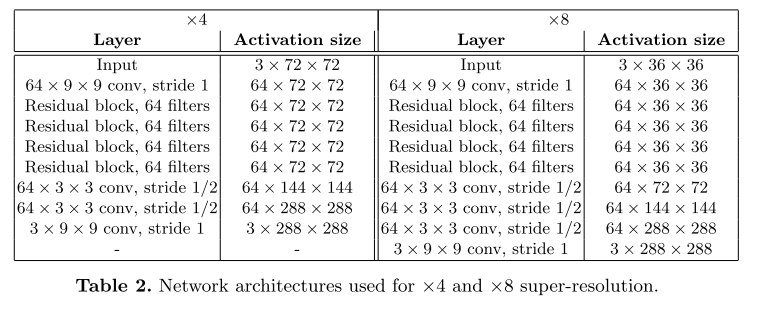

In [88]:
img = Image.open( "/home/sravya/Documents/SR/SR_arch.png"); img

# Create network for 4x resolution upscale

In [35]:
arr_lr.shape[1:]

(72, 72, 3)

In [36]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [37]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=deconv_block(x, 64, 3, (144, 144, 64))
x=deconv_block(x, 64, 3, (288, 288, 64))
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x) #Why is this?

# Create loss function

Create 2 models at block2_conv2 layer of VGG
  1. From OP of Image transformation network
  2. From HR image

In [38]:
preproc_lambda = Lambda(preproc)

In [39]:
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)

In [40]:
vgg_hr_image = vgg_content(preproc_lambda(vgg_inp))

In [41]:
vgg_it_op = vgg_content(preproc_lambda(outp))

In [42]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_it_op])

In [43]:
loss

<tf.Tensor 'Sqrt_49:0' shape=(?, 128) dtype=float32>

# Create the final model and fit 

In [44]:
sr_model = Model([inp, vgg_inp], loss)
sr_model.compile('adam', 'mse')

In [ ]:
targ = np.zeros((arr_hr.shape[0], 128))
sr_model.fit([arr_lr, arr_hr], targ, 8, 2)

Epoch 1/2
 9056/19439 [============>.................] - ETA: 423s - loss: 53925.8409  

# Create the Image transformation model and save weights for inference

In [ ]:
it_model = Model(inp, outp)
it_model.save_weights('/home/sravya/data/SR/weights/'+'it.h5')

In [45]:
it_model = Model(inp, outp)
it_model.load_weights('/home/sravya/data/SR/weights/'+'it.h5')

# Explore results

In [167]:
p = it_model.predict(arr_lr[0:100])

In [209]:
def compare_pics(x,y):
    fig = plt.figure(figsize=(40,40))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(x)
    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(y)

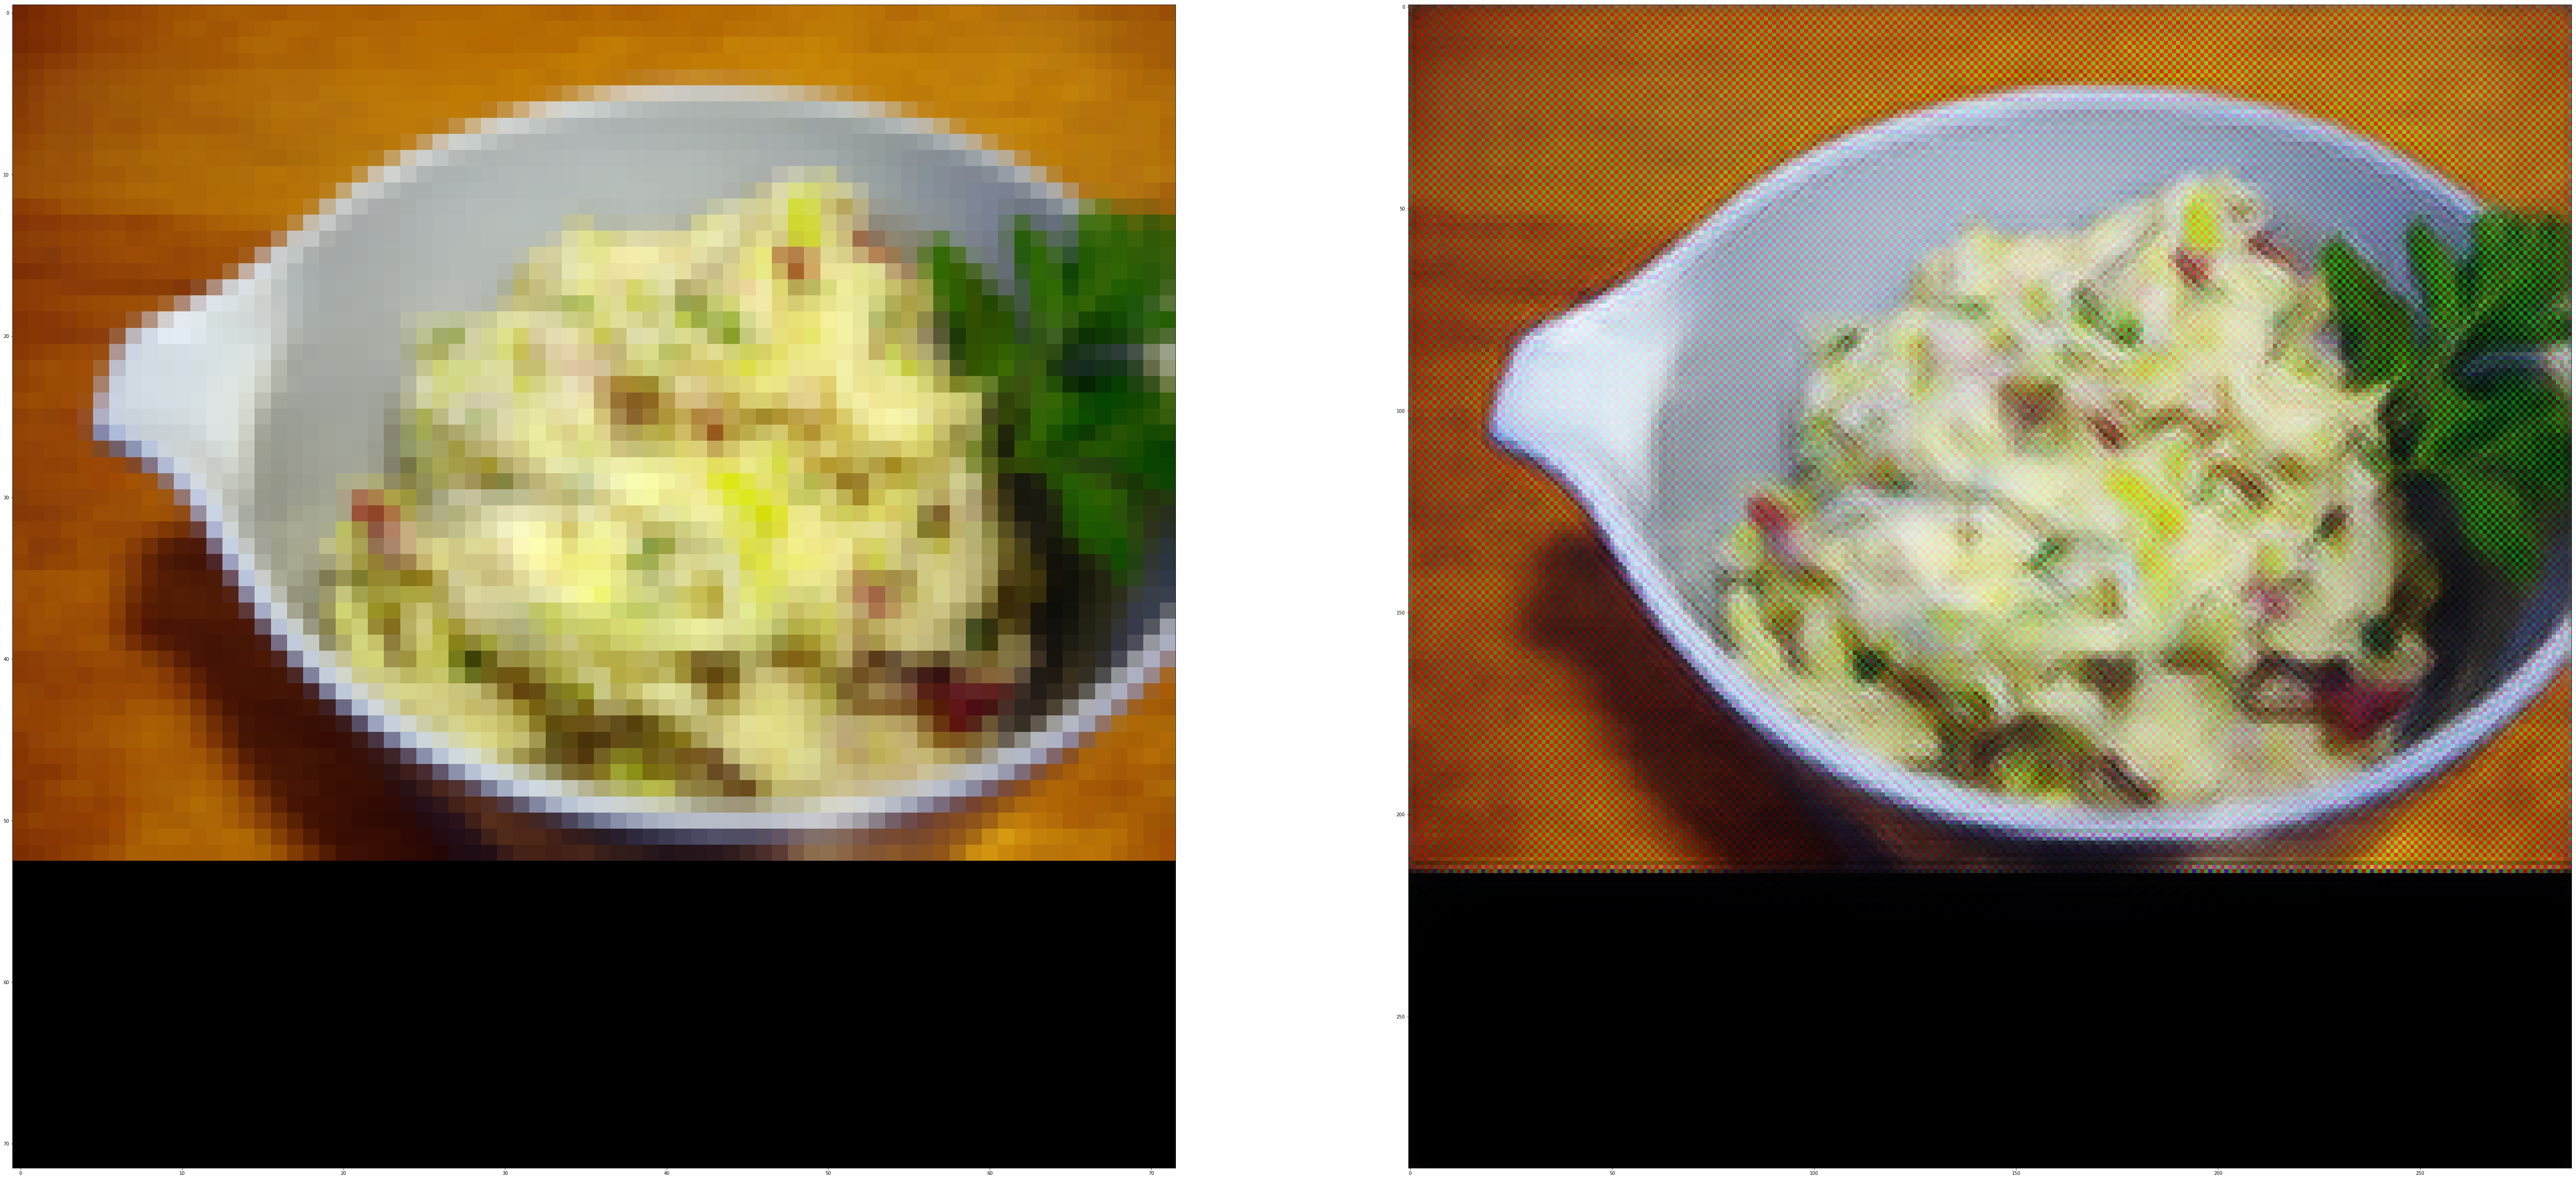

In [169]:
compare_pics(arr_lr[10].astype('uint8'), p[10].astype('uint8'))

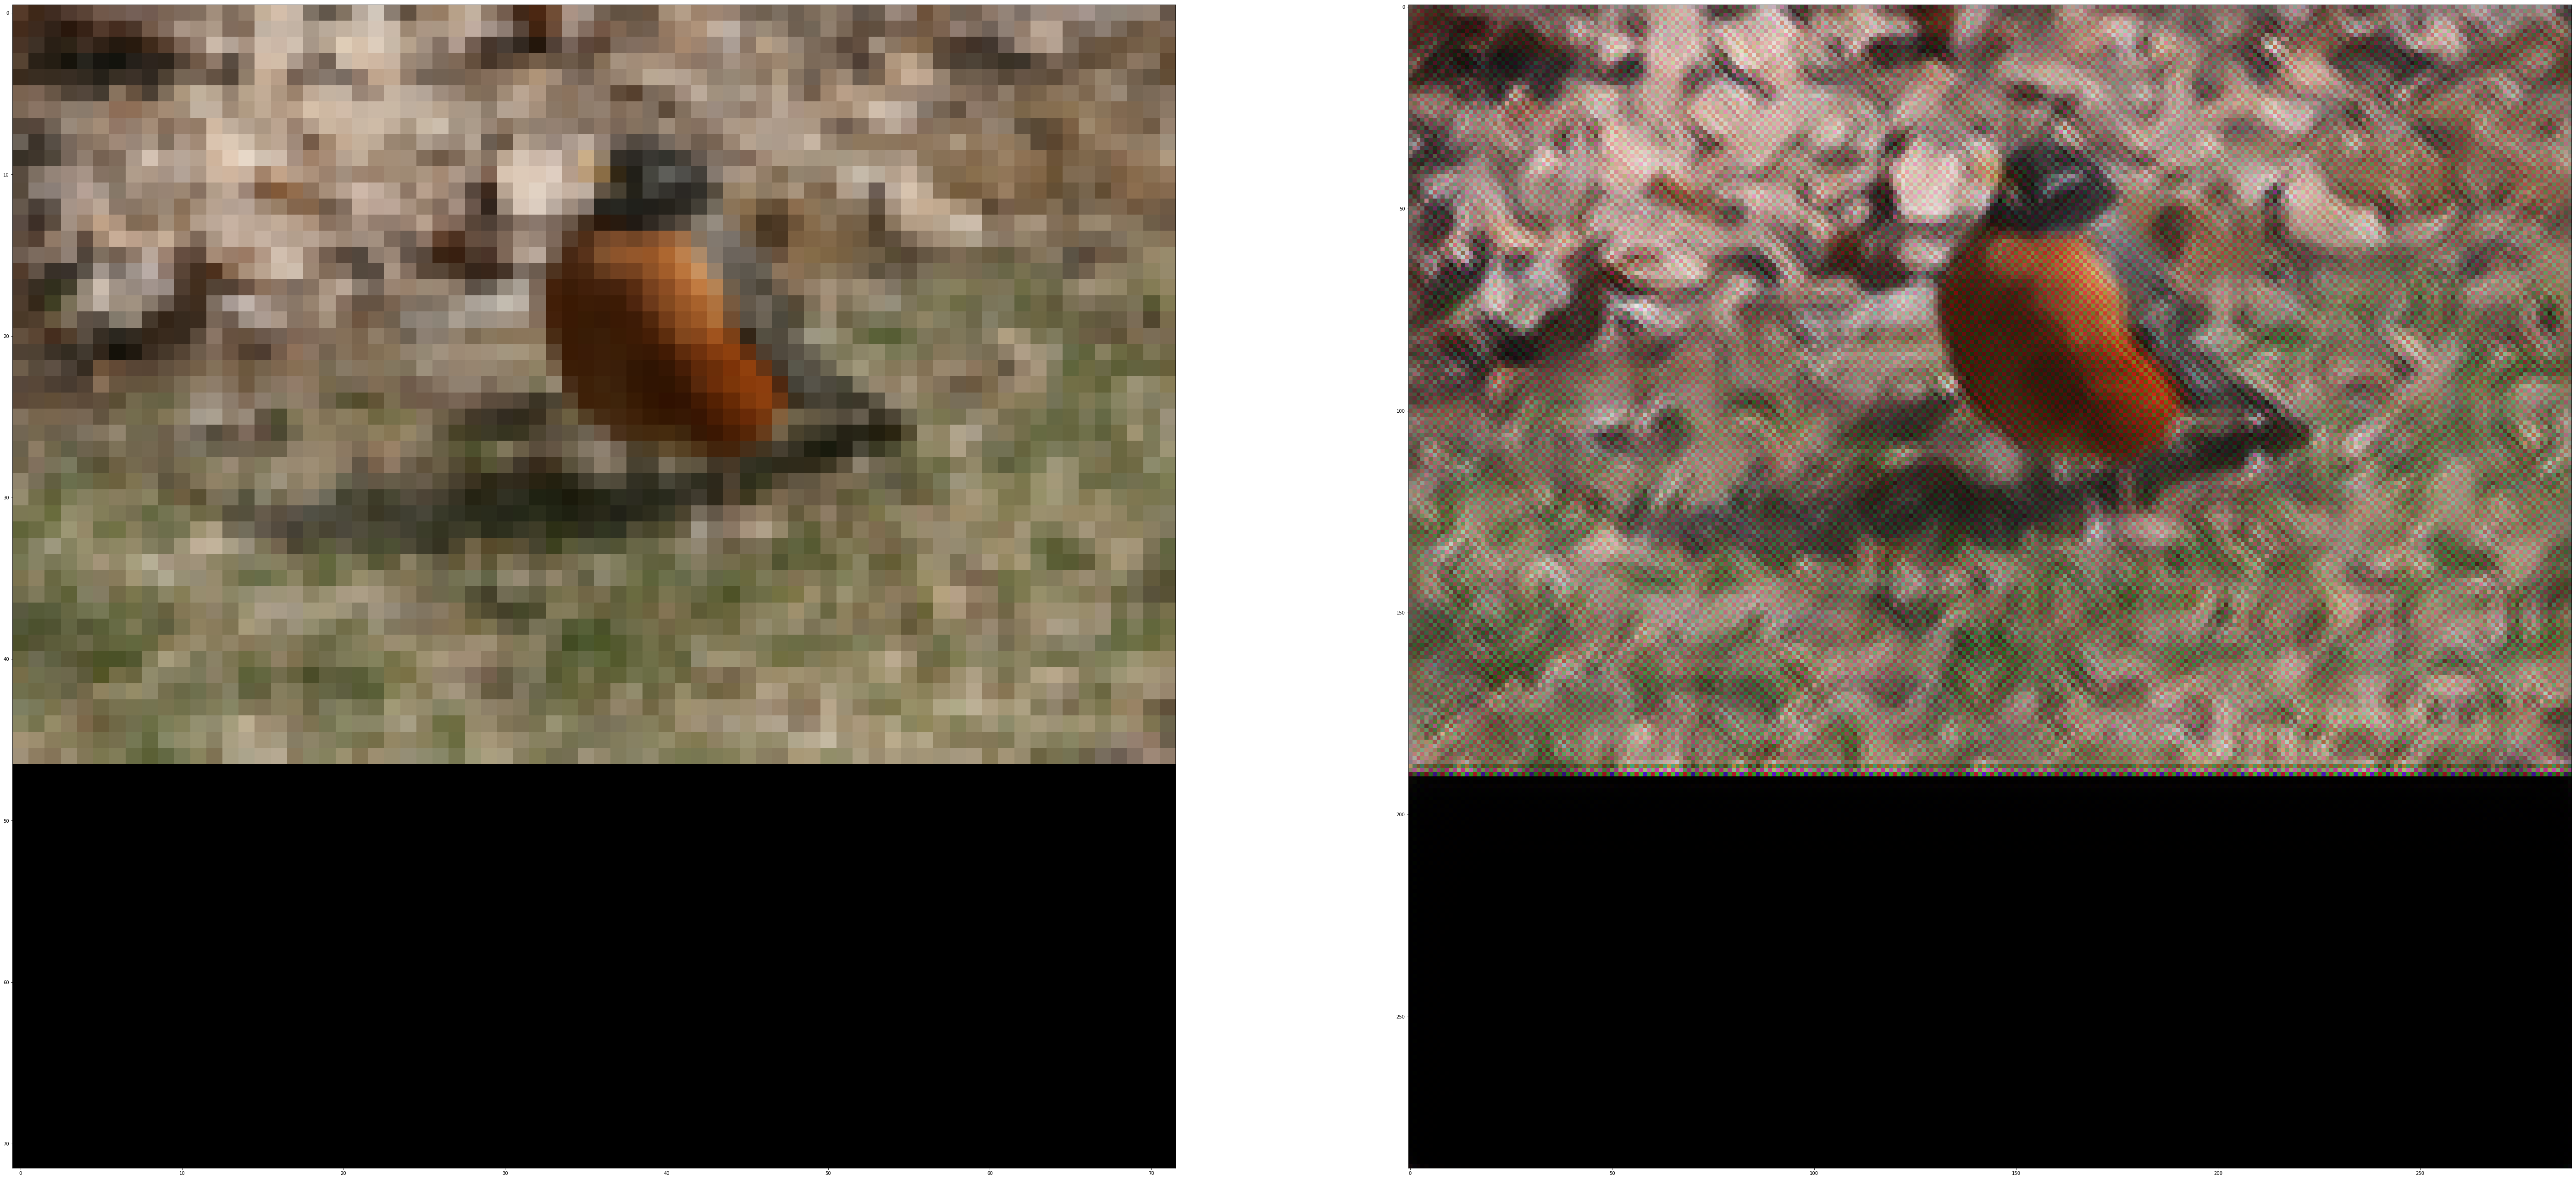

In [170]:
compare_pics(arr_lr[40].astype('uint8'), p[40].astype('uint8'))

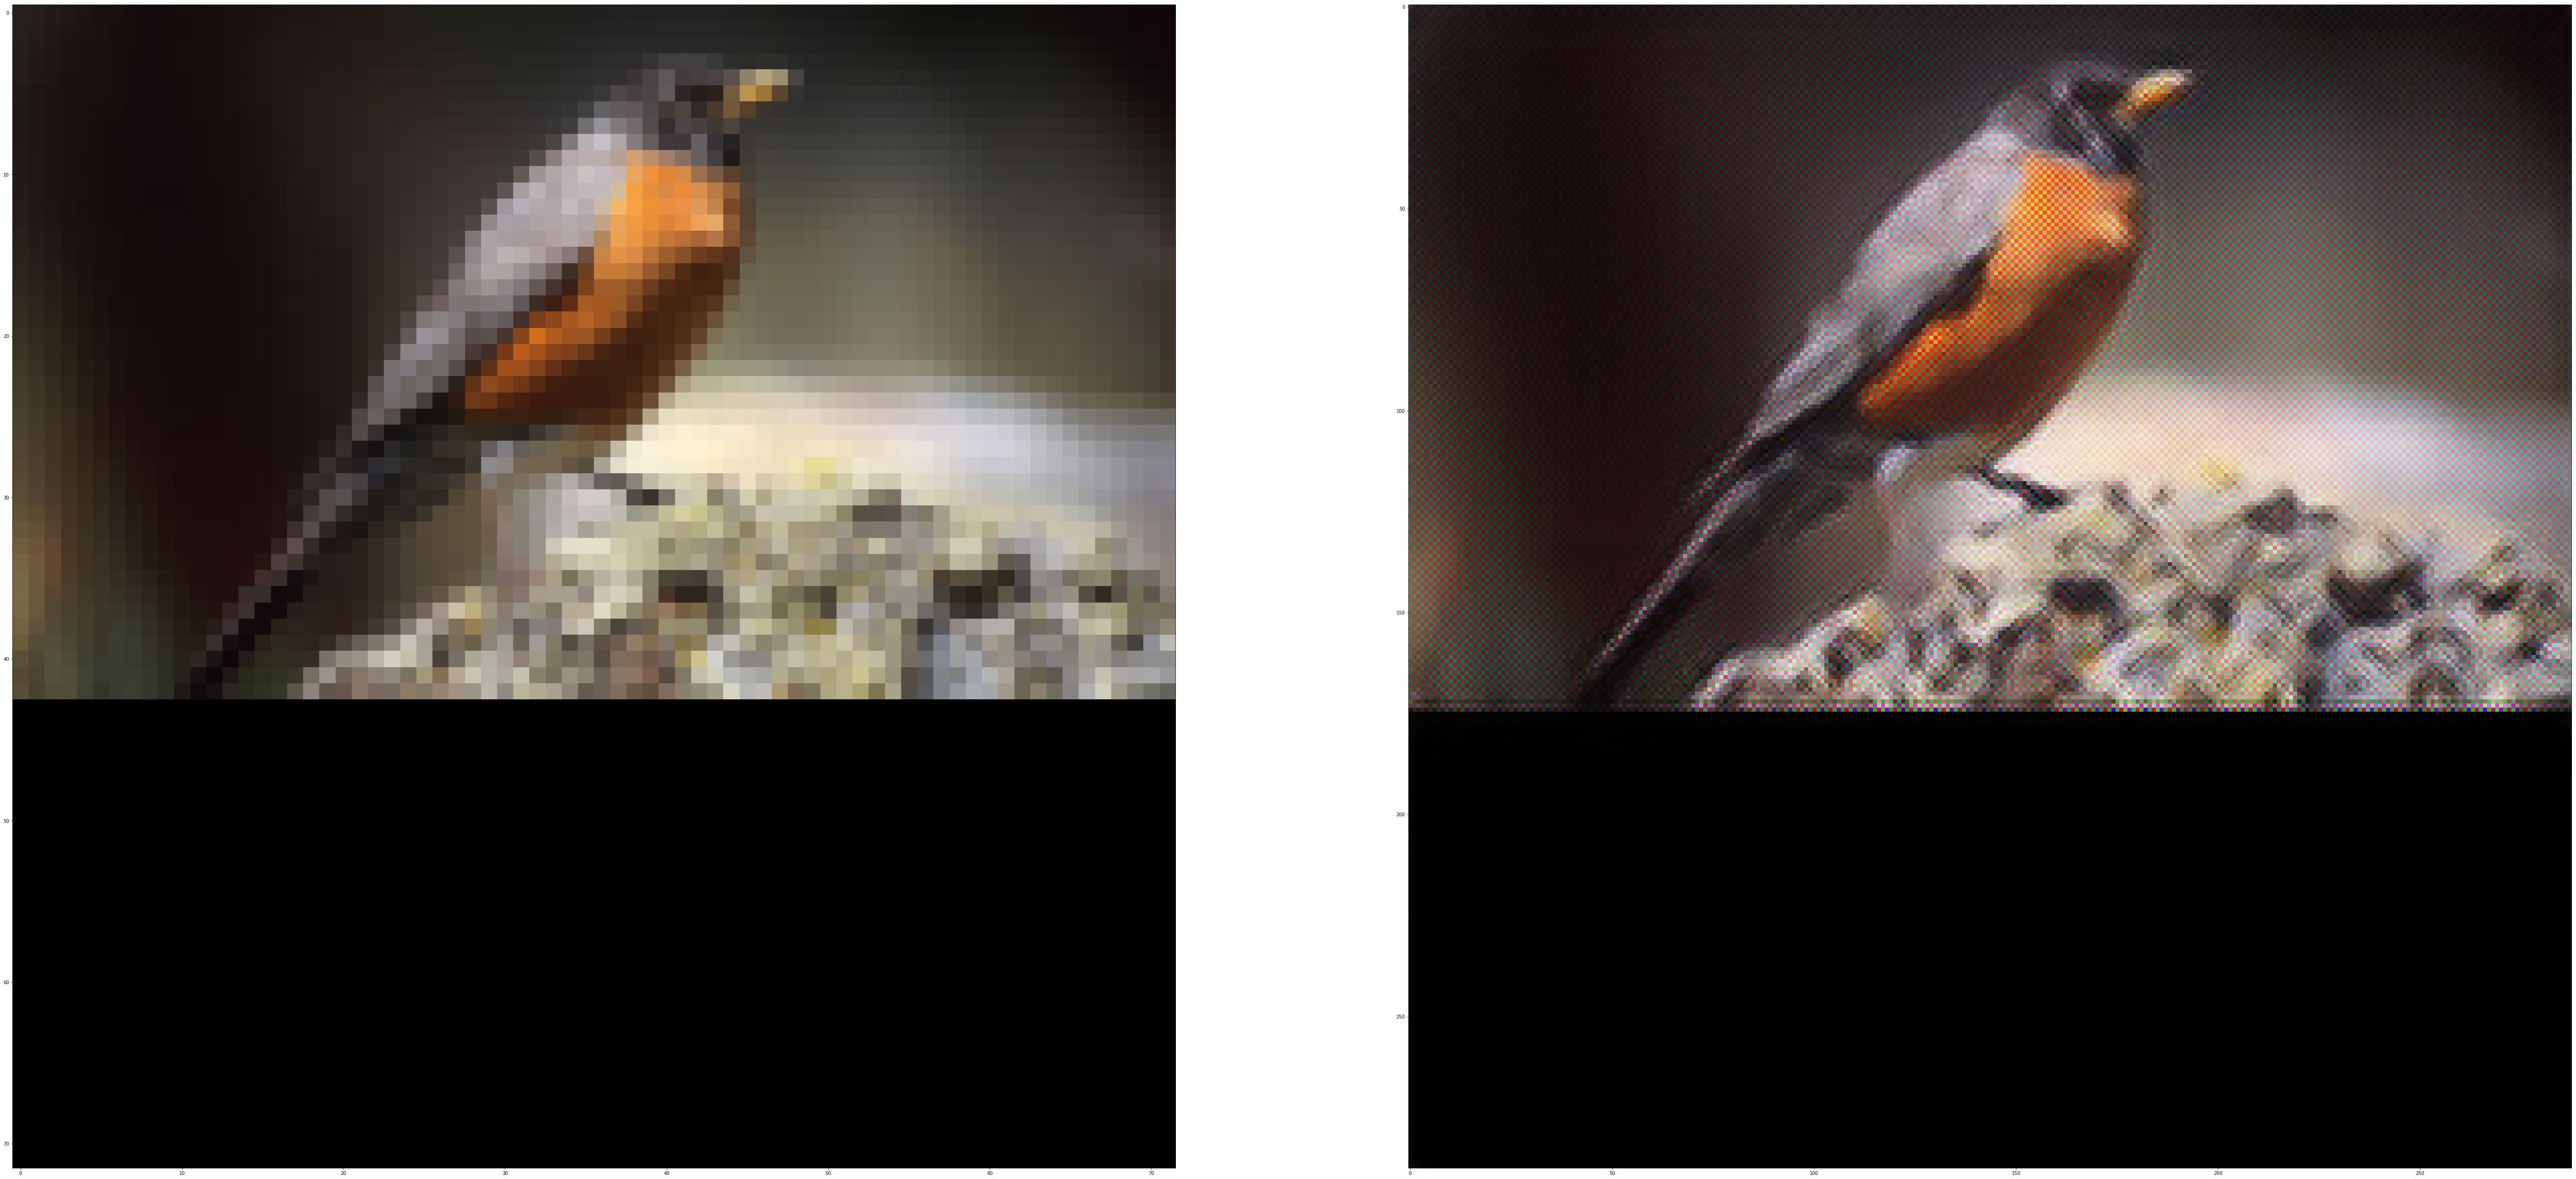

In [171]:
compare_pics(arr_lr[50].astype('uint8'), p[50].astype('uint8'))

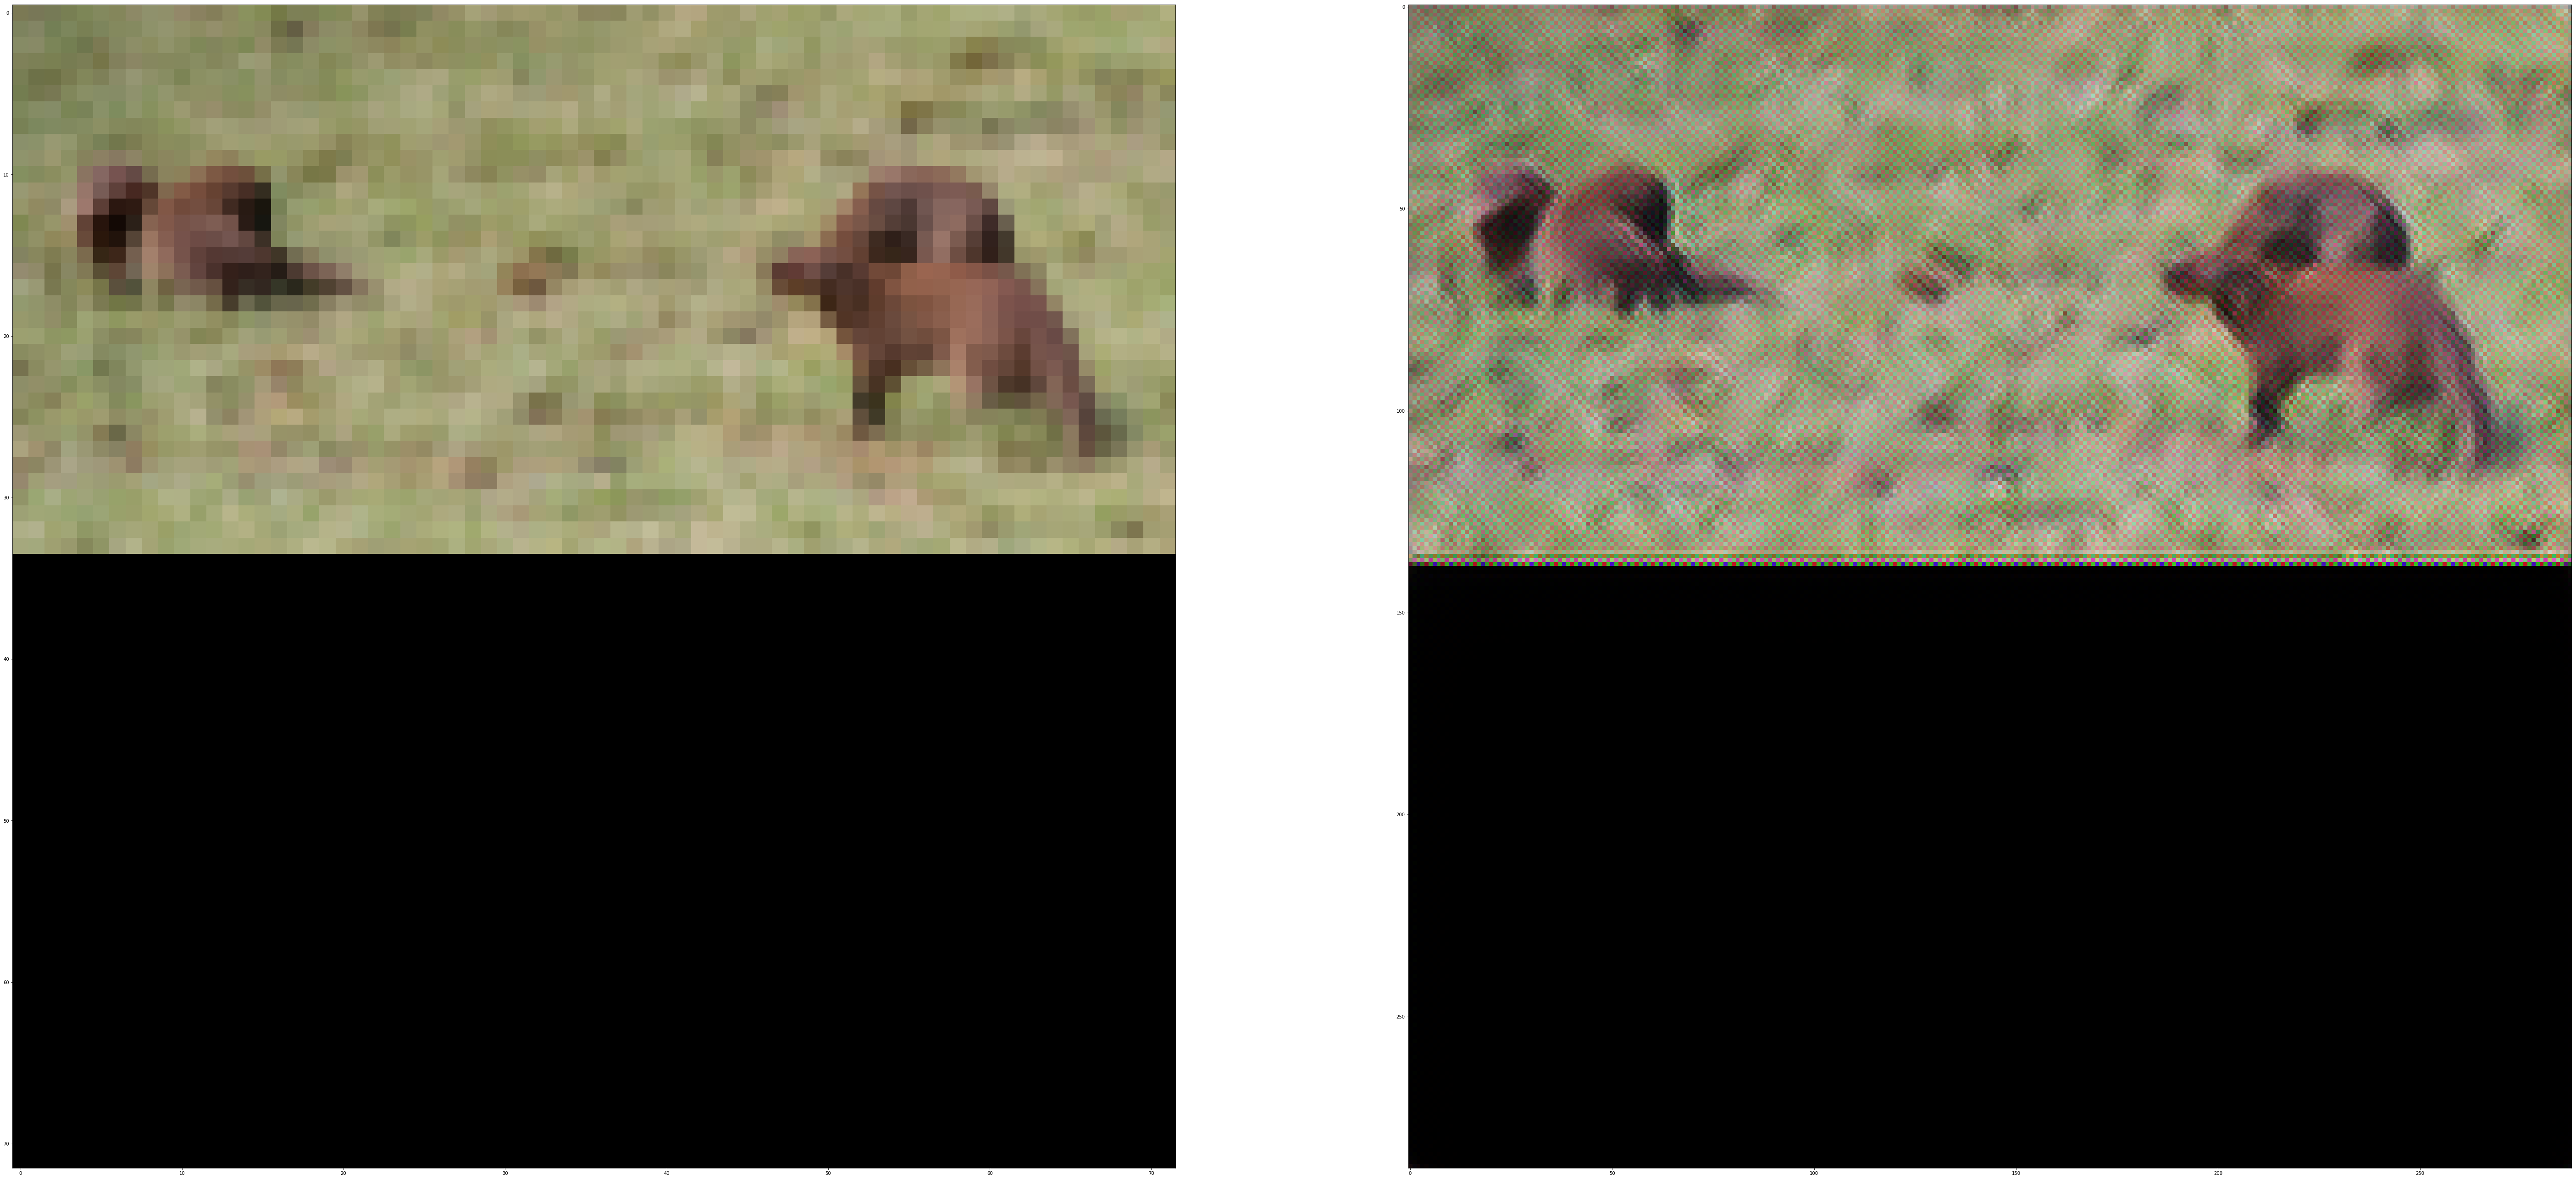

In [172]:
compare_pics(arr_lr[88].astype('uint8'), p[88].astype('uint8'))

In [211]:
img = Image.open('/home/sravya/Pictures/profile.jpg');img.size

(720, 960)

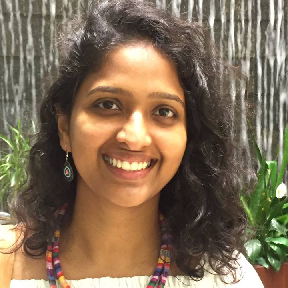

In [212]:
orig_img = img.crop([0,80, 720, 720 +80]).resize((288,288));orig_img

In [213]:
orig_arr = np.array(orig_img)
lr_arr = np.array(orig_img.resize((72,72)))

In [214]:
p = it_model.predict(np.expand_dims(lr_arr, 0))

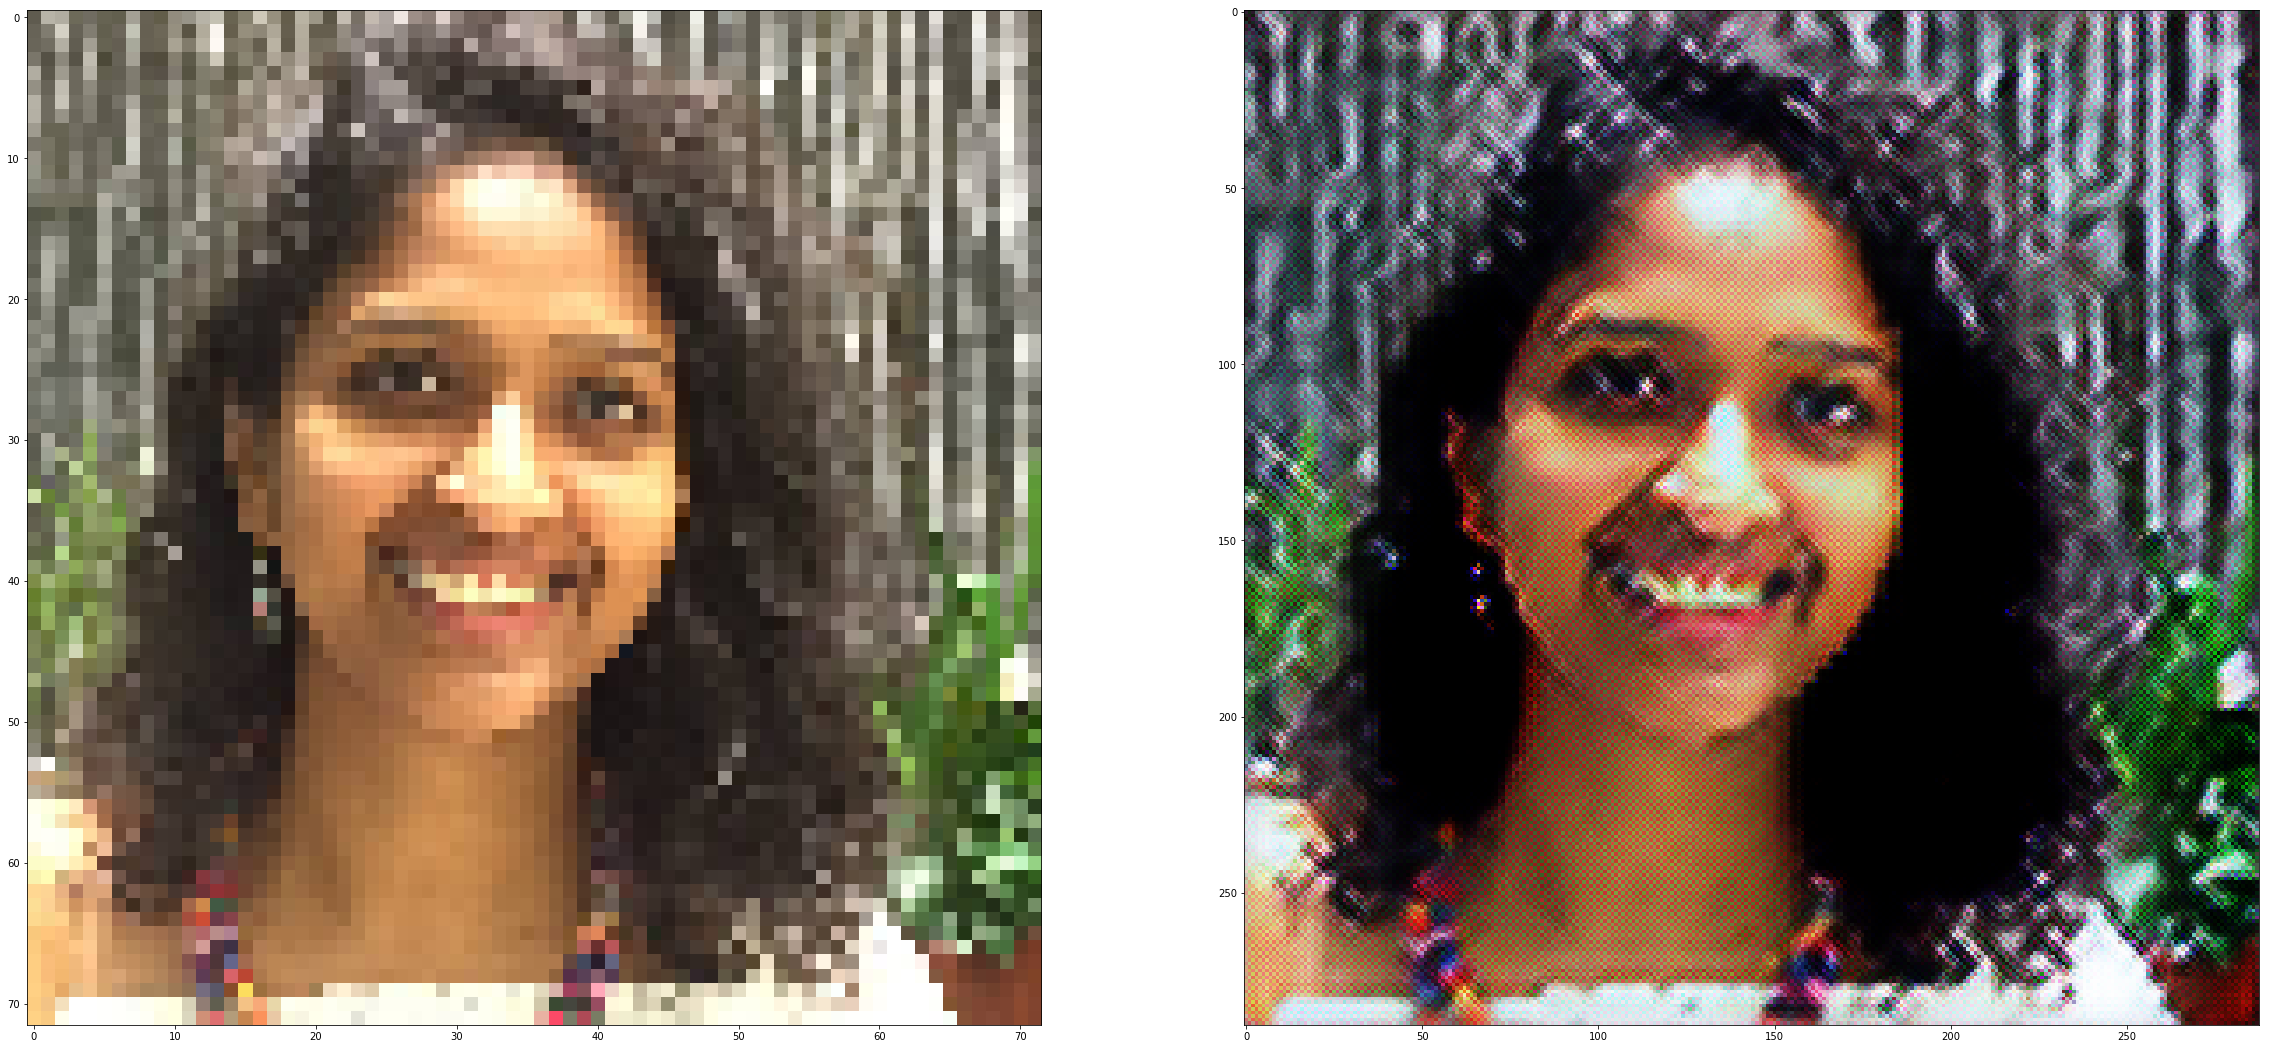

In [215]:
compare_pics(lr_arr, p[0].astype('uint8'))

In [190]:
img = Image.open('/home/sravya/Pictures/taj_mahal.jpg');img.size

(660, 413)

In [192]:
orig_img = img.crop([190,20, 288 +190,288+20])
orig_arr = np.array(orig_img)
lr_arr = np.array(orig_img.resize((72,72)))

In [193]:
p = it_model.predict(np.expand_dims(lr_arr, 0))

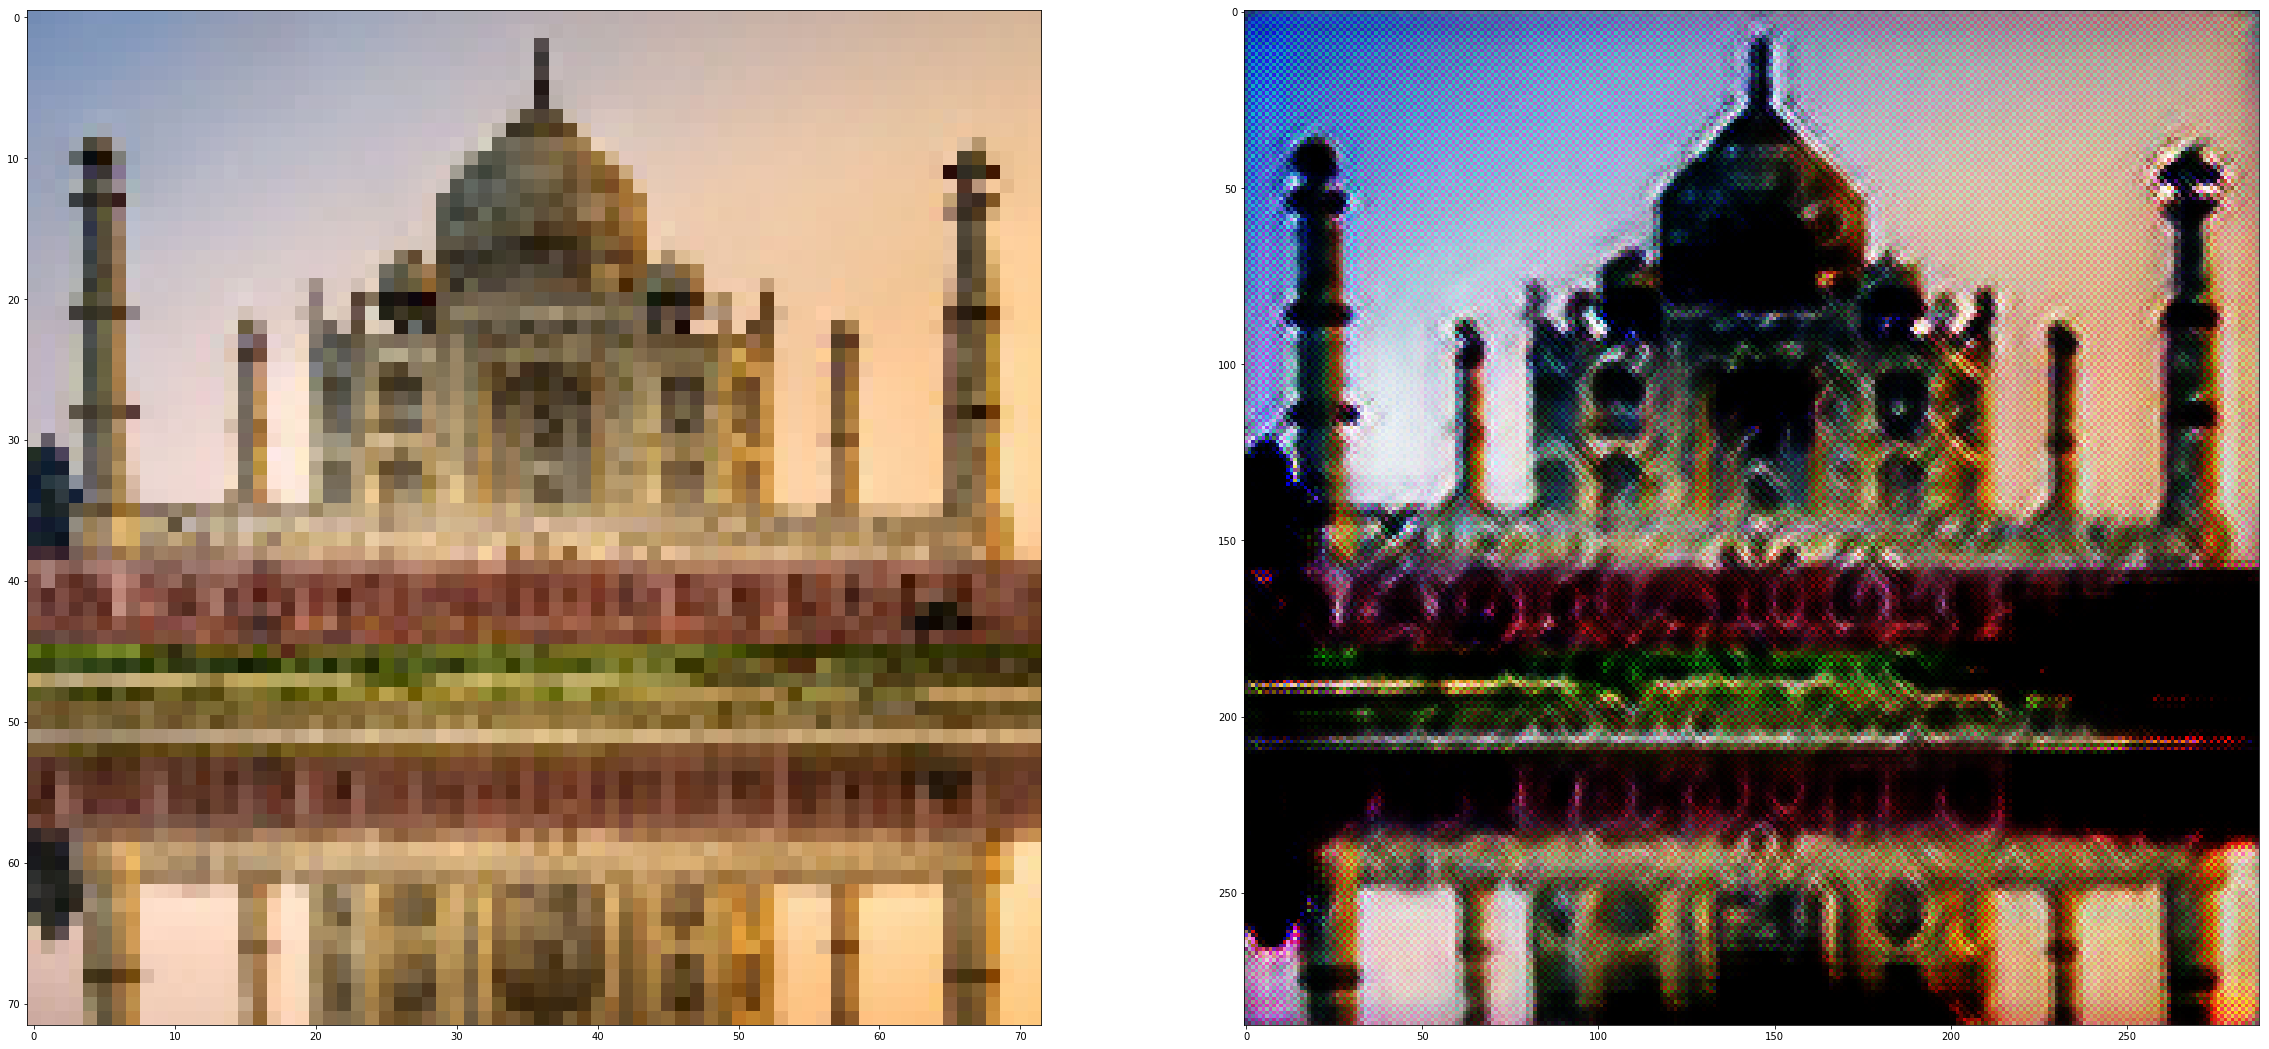

In [210]:
compare_pics(lr_arr, p[0].astype('uint8'))

# Try

In [4]:
[1]*4 + [0]*4

[1, 1, 1, 1, 0, 0, 0, 0]